### [4 балла] Ответы на вопросы голосом

Демо готово! Но кто хочет писать вопросы текстом?
Здесь вам предстоить улучшить ваше демо, чтобы оно могло принимать вопросы голосом. За основу вам предлагается рассмотреть демо https://www.gradio.app/guides/real-time-speech-recognition и добавить соответствуещее окошко в ваше демо. Также вы можете добавить text-to-speech модель, чтобы оно озвучило текстовый ответ (дополнительный балл к оценке)

---

**Ожидаемый результат**

В качестве результата в этой секции вам нужно код для запуска демо на градио и видеозапись его работы, где реализован описанный выше функционал.

# План решения

Ниже представлен код для реализации демо для этой части ДЗ на gradio с использованием голосового ввода и вывода. Использовать буду в Space Hugging Face
Ссылка на Space https://huggingface.co/spaces/Shakhovak/HW3_Speech_VQA
Как я поняла из документации Hugging Face, он будет работать 48 часов с запуска или прихода последнего пользователя, потом перезапускается с приходом нового пользователя.

Код ниже адаптирован для Space: добавлены файлы requirements.txt + packages.txt

Также записала свою работу со Space (на примере файлов из examples + скан рандомного счета). Запись с субтитрами по ссылке на google drive, доступ публичный https://drive.google.com/file/d/1p1SH3fImPfTv6iRpKb79uyvYBMOioP7q/view?usp=sharing

Локально не запускаю, так как не машине нет tessaract-ocr, модель VQA работает только в Space, но оболочка gradio запускается.

In [1]:
import torch
import gradio as gr
from transformers import pipeline
import numpy as np

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

nlp = pipeline(task =  "document-question-answering",
    model='impira/layoutlm-document-qa', device = device)

ru_en = pipeline("translation", model="Helsinki-NLP/opus-mt-ru-en", device = device)
en_ru = pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru", device = device)

transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-base")


def transcribe(audio, qu_language):
    sr, y = audio
    y = y.astype(np.float32)
    y /= np.max(np.abs(y))
    return transcriber({"sampling_rate": sr, "raw": y, "task":"transcribe", "language":qu_language})["text"]

def image_recognition_translation(image, audio, qu_language):
    question = transcribe(audio, qu_language)
    if qu_language == 'russian':
        question = ru_en(question)[0]['translation_text']
    answer =  nlp(image, question)[0]['answer']
           
    return answer

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")


speaker_embeddings = {
    "BDL": "cmu_us_bdl_arctic-wav-arctic_a0009.npy",
    "CLB": "cmu_us_clb_arctic-wav-arctic_a0144.npy",
}


def audio_VQA(image, qu_language, audio, speaker):
    text = image_recognition_translation(image, audio, qu_language)
    
    if len(text.strip()) == 0:
        return (16000, np.zeros(0).astype(np.int16))

    inputs = processor(text=text, return_tensors="pt")

    # limit input length
    input_ids = inputs["input_ids"]
    input_ids = input_ids[..., :model.config.max_text_positions]

    speaker_embedding = np.load(speaker_embeddings[speaker[:3]])
    speaker_embedding = torch.tensor(speaker_embedding).unsqueeze(0)
    speech = model.generate_speech(input_ids, speaker_embedding, vocoder=vocoder)
    speech = (speech.numpy() * 32767).astype(np.int16)
    return (16000, speech)

title = "Interactive demo: SPEECH visual question answering (VQA) with language multiple choice"
description = "Gradio Demo for HW3 part 3. This demo requires image and voice question related to image content as input as well as question/answer language. As output the model finds the answer in the doc and voices it"

outputs = gr.Audio(label="Answer voiced by model", type="numpy")

theme = 'huggingface'

interface = gr.Interface(fn=audio_VQA, 
                         inputs=[gr.Image(type="pil", label = 'Image for analysis'),
                                 gr.Radio(choices = ["english", "russian"], label="Question/Answer Language", info="Pick up the language of the the quesiton/answer",
                                         value = 'english'),
                                 gr.Audio(sources=["microphone"], label = 'Ask me a question'),
                                 gr.Radio(label="Type of voice", choices=[
                                                                    "BDL (male)",
                                                                    "CLB (female)",
                                                                             ],
                                                                value="BDL (male)")
                                                                       ],
                         outputs=outputs,
                         title=title,
                         description=description,
                        )

if __name__ == "__main__":
    interface.launch(debug=True, share = True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1fb6da4afb1594d190.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1fb6da4afb1594d190.gradio.live


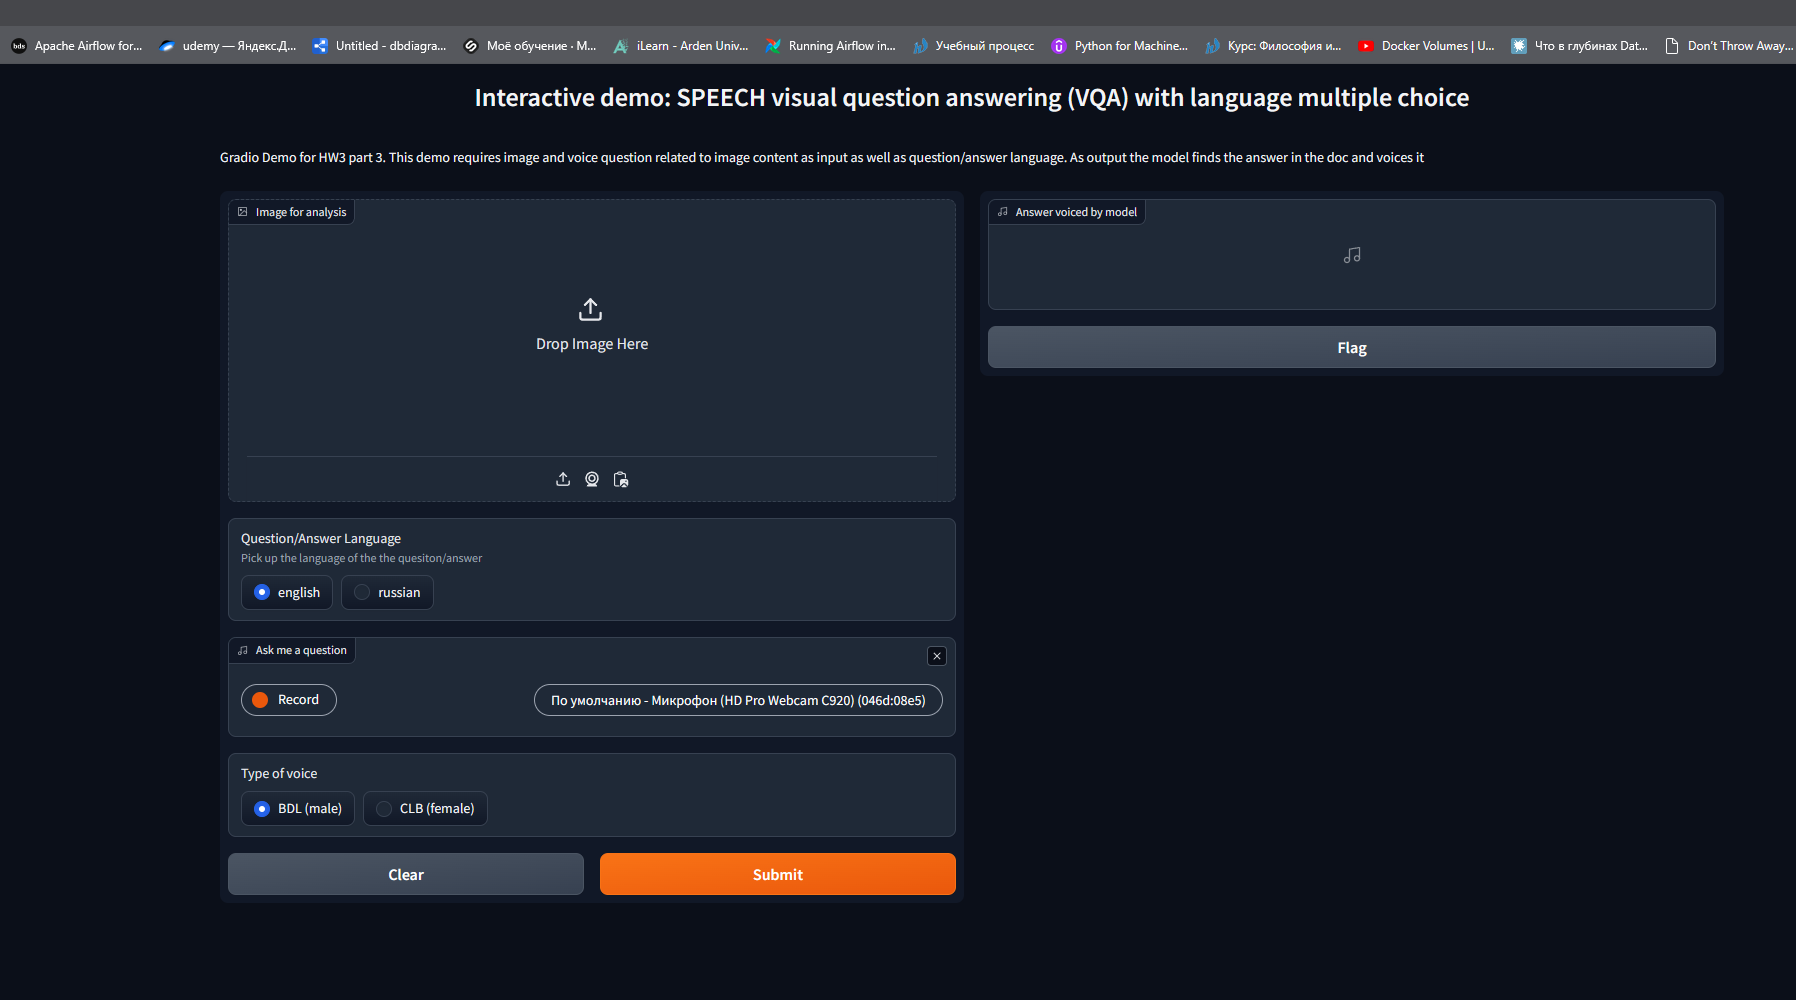